# Pipeline to build images from matrices.
- Input: 2D matrix 800x19
- Output: 3D (500, 314, 3) Matrix stored as DenseVector of size 471000.
- For each Row, use sciki-image to create a geometrical shape (represented as numpy arrays)

In [1]:
qcd_features = sqlContext.read.format("parquet").load("file:/Users/vk/data/ML_MP_JR/parquet/qcd")
ttbar_features = sqlContext.read.format("parquet").load("file:/Users/vk/data/ML_MP_JR/parquet/ttbar")
wjets_features = sqlContext.read.format("parquet").load("file:/Users/vk/data/ML_MP_JR/parquet/wjets")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os
from pyspark.sql import Row
from scipy import misc
from skimage import draw

In [3]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors, Matrices

In [4]:
feature_variables = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]


# In[259]:

colors = {'isMu' : 'green',
        'isEle': 'green',
         'isGamma':'blue',
         'isChHad' : 'red',
         'isNeuHad': 'yellow'}

shapes = {'isMu' : 5,
          'isEle': 5,
          'isGamma':3,
          'isChHad' : 4,
          'isNeuHad': 0}

c_colors = [colors[k] for k in feature_variables[13:]]+['black']
cc_colors = [np.asarray(matplotlib.colors.to_rgb(k)) for k in c_colors]
cc_shapes = [shapes[k] for k in feature_variables[13:]]+[0]

print c_colors
print cc_colors
print cc_shapes

['red', 'yellow', 'blue', 'green', 'green', 'black']
[array([ 1.,  0.,  0.]), array([ 1.,  1.,  0.]), array([ 0.,  0.,  1.]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.,  0.,  0.])]
[4, 0, 3, 5, 5, 0]


In [5]:
def showImage(image):
    fig = plt.figure(frameon=False)
    plt.imshow(image.swapaxes(0,1))
    plt.axis('off')
    plt.show()

def create3D(data):
    max_eta = 5
    max_phi = np.pi
    res= 100
    neta = int(max_eta*res)
    nphi = int(max_phi*res)
    eeta = 2.*max_eta / float(neta)
    ephi = 2.*max_phi / float(nphi)
    def ieta( eta ): return (eta+max_eta) / eeta
    def iphi(phi) : return (phi+max_phi) / ephi
    blend = 0.3
    image = np.ones((neta,nphi,3), dtype = np.float32)
    
    before_loop = time.time()
    for ip in range(data.shape[0]):
        p_data = data[ip,:]
        eta = p_data[0]
        phi = p_data[1]
        if eta==0 and phi==0: 
            #print ip
            continue
        #pT = p_data[2]
        #lpT = min(max(np.log(pT)/5.,0.001), 10)*res/2.
        lpT = p_data[2]
        ptype = int(p_data[3])
        c = cc_colors[ ptype ]
        s = cc_shapes[ ptype ]
        R = lpT * res/1.5
        iee = ieta(eta)
        ip0 = iphi(phi)
        ip1 = iphi(phi+2*np.pi)
        ip2 = iphi(phi-2*np.pi)
        
        if s==0:
            xi0,yi0 = draw.circle(  iee, ip0,radius=R, shape=image.shape[:2])
            xi1,yi1 = draw.circle( iee, ip1, radius=R, shape=image.shape[:2])
            xi2,yi2 = draw.circle( iee, ip2, radius=R, shape=image.shape[:2]) 
            #if ptype == 5:
            #    print "MET",eta,phi
        else:
            nv = s
            vx = [iee + R*np.cos(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy = [ip0 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy1 = [ip1 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy2 = [ip2 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            xi0,yi0 = draw.polygon( vx, vy , shape=image.shape[:2])
            xi1,yi1 = draw.polygon( vx, vy1 , shape=image.shape[:2])
            xi2,yi2 = draw.polygon( vx, vy2 , shape=image.shape[:2])
            
        xi = np.concatenate((xi0,xi1,xi2))
        yi = np.concatenate((yi0,yi1,yi2))
        image[xi,yi,:] = (image[xi,yi,:] *(1-blend)) + (c*blend)
    after_loop = time.time()
    print "Time to process the loop inside create3D : %3.3f" % (after_loop - before_loop)
    return Vectors.dense(image.reshape((neta*nphi*3)))


def convert2image(row):
    """Assume that a row contains a non-empty 2D matrix of features"""
    start = time.time()
    #
    # this is for avoiding clashes on CC7 and SLC6 of the python versions
    #
    if np.__version__!="1.13.3":
        import sys
        sys.path.insert(0, "/afs/cern.ch/user/p/pkothuri/.local/lib/python2.7/site-packages")
        reload(np)
    
    lmat = np.asarray(row.lfeatures, dtype=np.float32)
    hmat = np.asarray(row.hfeatures, dtype=np.float32)
    
    # low level features
    l_reduced = np.asarray(np.zeros((lmat.shape[0], 4)))
    l_reduced[:, 0] = lmat[:, 5]
    l_reduced[:, 1] = lmat[:, 6]
    l_reduced[:, 2] = np.minimum(np.log(np.maximum(lmat[:, 4], 1.001))/5., 10)
    l_reduced[:, 3] = np.argmax(lmat[:, 13:], axis=-1)
    
    # high level features
    h_reduced = np.zeros( (1, 4))
    h_reduced[0,2] = np.minimum(np.maximum(np.log(hmat[1])/5.,0.001), 10) # MET
    h_reduced[0,1] = hmat[2] # MET-phi
    h_reduced[0,3] = int(5) ## met type
    
    # concatenate the high and low level features
    reduced = np.concatenate((l_reduced, h_reduced), axis=0)
    
    # geneate the image (as a 3D matrix)
    before_create3D = time.time()
    img = create3D(reduced)
    
    before_tolist = time.time()
    l = img
    end = time.time()
    
    print "Tiem to procss a Row before create3D: %3.3f" % (before_create3D - start)
    print "Time to process a Row: %3.3f" % (end - start)
    print "Time to run tolist: %3.3f" % (end - before_tolist)
    
    return Row(image=l)

In [6]:
before = time.time()
qcd_images = qcd_features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 3 seconds


In [7]:
before = time.time()
ttbar_images = ttbar_features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 1 seconds


In [8]:
before = time.time()
wjets_images = wjets_features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 1 seconds


In [9]:

sample_qcd = qcd_features.take(10)
new_rows = []
for row in sample_qcd:
    new_rows.append(convert2image(row))
for row in new_rows:
    print row.image.array.shape

Time to process the loop inside create3D : 0.211
Tiem to procss a Row before create3D: 0.002
Time to process a Row: 0.219
Time to run tolist: 0.000
Time to process the loop inside create3D : 0.253
Tiem to procss a Row before create3D: 0.001
Time to process a Row: 0.259
Time to run tolist: 0.000
Time to process the loop inside create3D : 0.167
Tiem to procss a Row before create3D: 0.002
Time to process a Row: 0.172
Time to run tolist: 0.000
Time to process the loop inside create3D : 0.143
Tiem to procss a Row before create3D: 0.001
Time to process a Row: 0.147
Time to run tolist: 0.000
Time to process the loop inside create3D : 0.097
Tiem to procss a Row before create3D: 0.002
Time to process a Row: 0.102
Time to run tolist: 0.000
Time to process the loop inside create3D : 0.169
Tiem to procss a Row before create3D: 0.001
Time to process a Row: 0.173
Time to run tolist: 0.000
Time to process the loop inside create3D : 0.114
Tiem to procss a Row before create3D: 0.001
Time to process a R

# Just for clarity, here is how these images would look like if you wanted to draw them!

In [10]:
qcd_test_images = qcd_images.take(10)
ttbar_test_images = ttbar_images.take(10)
wjets_test_images = wjets_images.take(10)

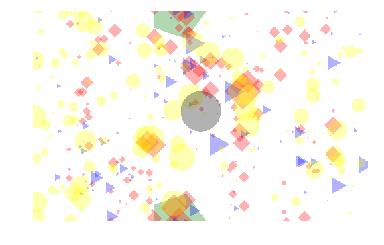

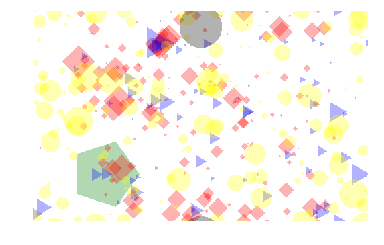

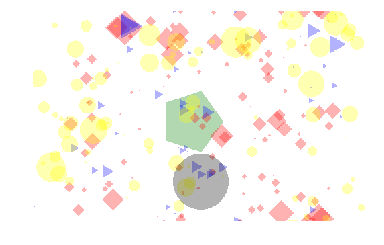

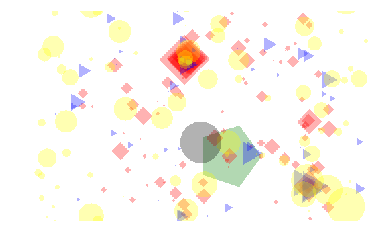

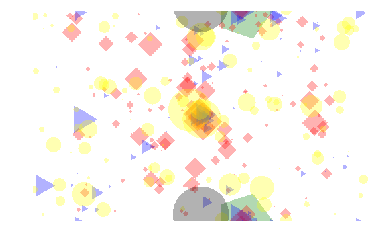

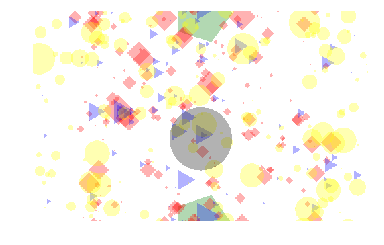

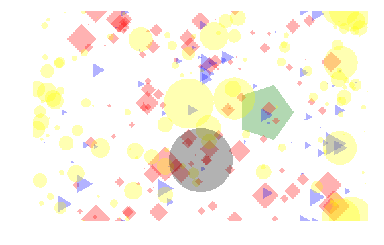

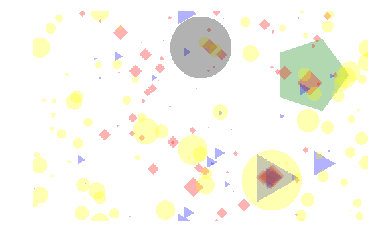

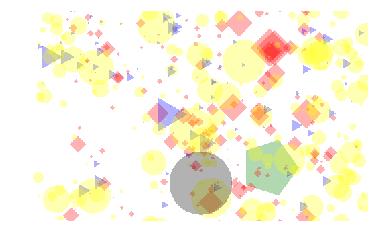

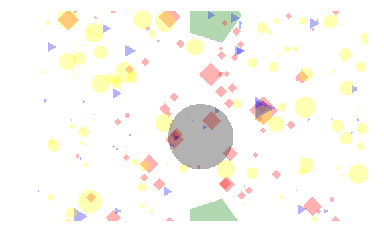

In [11]:
for x in qcd_test_images:
    img = x.image.array.reshape((500, 314, 3))
    showImage(img)

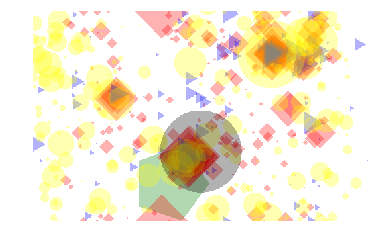

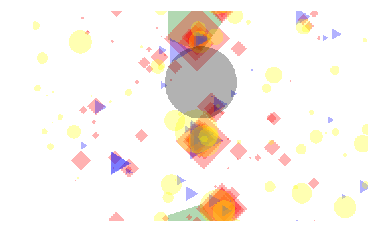

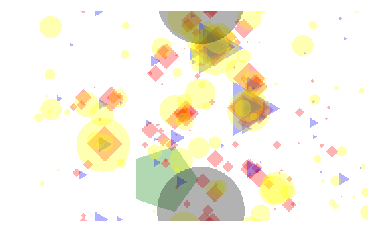

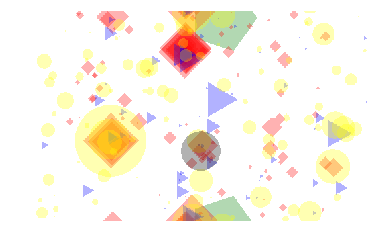

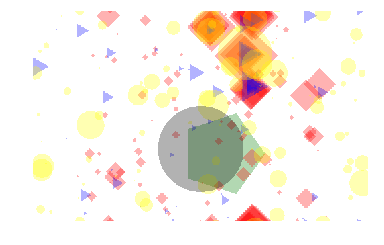

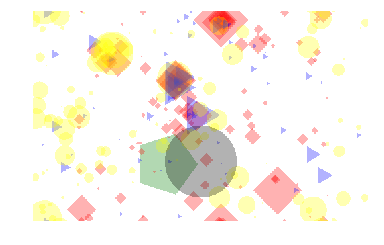

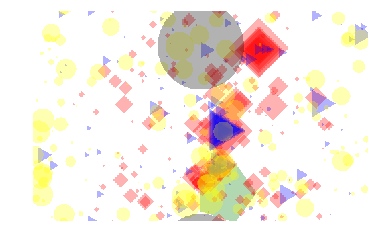

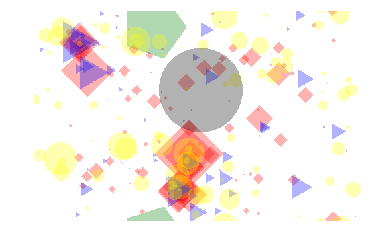

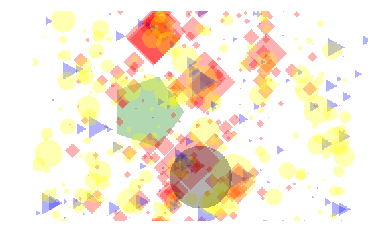

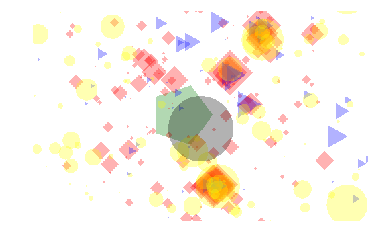

In [12]:
for x in ttbar_test_images:
    img = x.image.array.reshape((500, 314, 3))
    showImage(img)

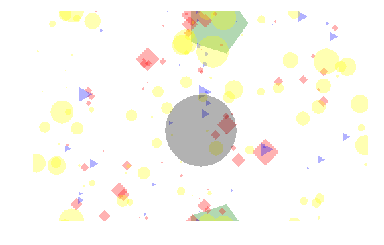

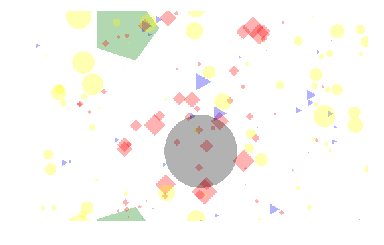

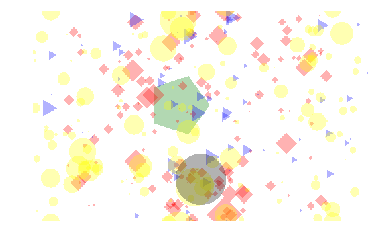

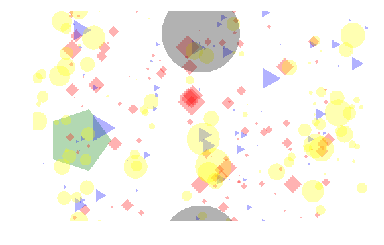

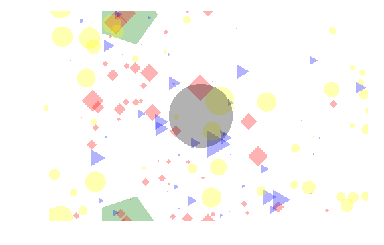

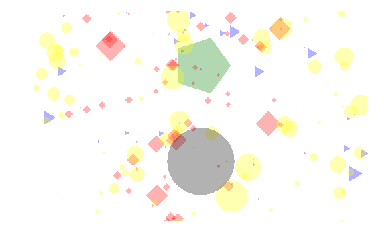

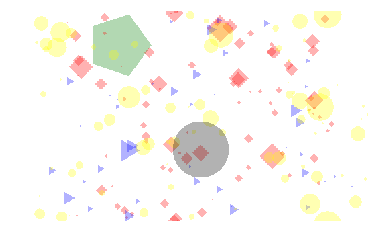

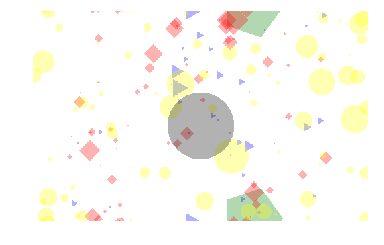

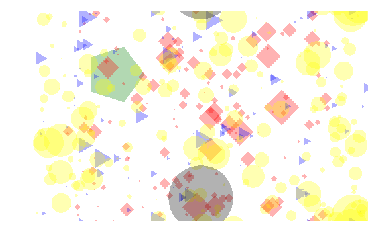

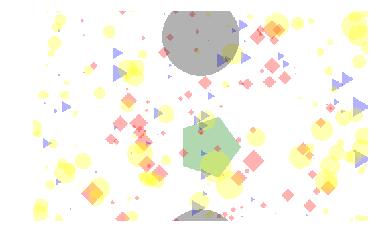

In [13]:
for x in wjets_test_images:
    img = x.image.array.reshape((500, 314, 3))
    showImage(img)

In [14]:
from pyspark.sql.functions import lit

In [15]:
qcd_label = 0
ttbar_label = 1
wjets_label = 2

#
# create new columns for that
#
qcd_sample = qcd_images.withColumn("label", lit(qcd_label))
ttbar_sample = ttbar_images.withColumn("label", lit(ttbar_label))
wjets_sample = wjets_images.withColumn("label", lit(wjets_label))

#
# combine all of that in just 1 data frame
#
data_sample = qcd_sample.union(ttbar_sample).union(wjets_sample)
#data_sample = qcd_sample.limit(10)

# Garbage Collection pauses start popping up once I'm trying to write to disk!
- Observe substantial GC pauses. Withuot waiting until the end of the job - i see ~20-30% of Duration (from Spark UI) to be occupied by GC

In [ ]:
data_sample.write.parquet("file:/Users/vk/data/ML_MP_JR/ttbar_lepFilter_13TeV/test_images_09012018", mode="overwrite")